# 2: PyTorch Neural Network Classification

In [3]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles

In [4]:
#Create dataset
n_samples = 1000

#Create circles
X, y = make_circles(
    n_samples,
    random_state = 42,
    noise = 0.03
)

In [5]:
len(X), len(y)

(1000, 1000)

In [7]:
print(f'First 5 of X: {X[:5]}')
print(f'First 5 of y: {y[:5]}')

First 5 of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 of y: [1 1 1 1 0]


In [8]:
#Make a DataFrame 
import pandas as pd
circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})

In [9]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


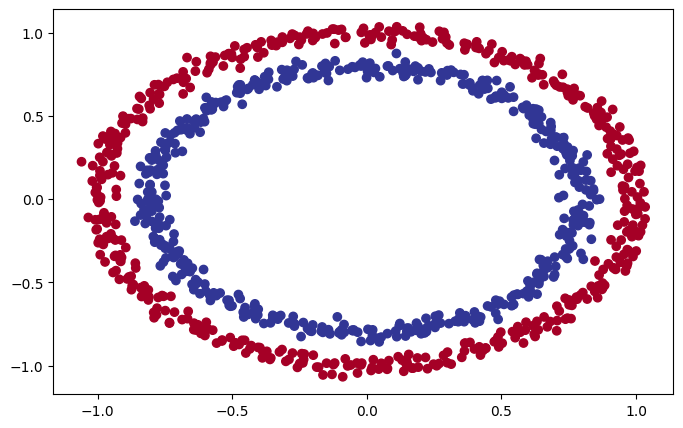

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
plt.scatter(
    x = circles['X1'],
    y = circles['X2'],
    c = circles['label'],
    cmap = plt.cm.RdYlBu
    )

### 1.1 Check input and output shapes

In [12]:
X.shape, y.shape

((1000, 2), (1000,))

In [15]:
X_sample = X[0]
y_sample = y[0]
X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), np.int64(1), (2,), ())

### 1.2 Data into Tensors and Split Data

In [16]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [17]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
#Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### 2. Building a Model

In [68]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [69]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [118]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #Create 2 nn.Linear layers that can handle our data
        self.layers = nn.Sequential(
            nn.Linear(in_features = 2, out_features = 10),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = 7),
            nn.ReLU(),
            nn.Linear(in_features = 7, out_features = 1)
        )

    def forward(self, x):
        return self.layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [119]:
#Replicate the model using nn.Sequential
'''model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.ReLU(),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)'''

'model_0 = nn.Sequential(\n    nn.Linear(in_features = 2, out_features = 5),\n    nn.ReLU(),\n    nn.Linear(in_features = 5, out_features = 1)\n).to(device)'

In [120]:
model_0

CircleModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [121]:
model_0.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layers.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layers.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.12

In [122]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

### 2.1 Setup Optimizer and Loss Function

In [123]:
#Loss Function
#nn.BCELoss requires the data to have already being pushed into sigmoid function
loss_fn = nn.BCEWithLogitsLoss() #Binary Cross Entropy with Sigmoid function built-in

#Optimizer
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.1
)

In [124]:
#Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Train Model

### 3.1 Going from raw logits -> Prediction Probabilities -> Prediction Labels
Model outputs are going to be raw logits

We convert them to prediction probabilities using the sigmoid function (softmax for multiclass). Then we convert the probabilities into labels by `round()` (`argmax()` for multiclass).

In [125]:
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.3773],
        [-0.3758],
        [-0.3548],
        [-0.3783],
        [-0.2976]], device='mps:0', grad_fn=<SliceBackward0>)

In [126]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4068],
        [0.4071],
        [0.4122],
        [0.4065],
        [0.4261]], device='mps:0', grad_fn=<SliceBackward0>)

In [127]:
#Find the predicted labels
y_preds = torch.round(y_pred_probs)

#In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_train.to(device))[:5]))

print(torch.eq(y_preds.squeeze()[:5], y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0',
       grad_fn=<SqueezeBackward0>)

### 3.2 Building a Training and Test Loop

In [128]:
torch.manual_seed(42)
epochs = 7001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Loop
for epoch in range(epochs):
    #Training
    model_0.train()
    #Forward Pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #logits to prob to class/pred labels
    #Loss and Accuracy
    loss = loss_fn(y_logits, y_train) #Must pass logits because of the loss function we chose
    accuracy = accuracy_fn(y_true = y_train, y_pred = y_pred)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Backpropagation
    loss.backward()
    #Gradient descent
    optimizer.step()
    ###Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true = y_test, y_pred = test_pred)
    #Print outputs
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_accuracy:.2f}")

Epoch: 0 | Loss: 0.70754, Acc: 50.00 | Test Loss: 0.70599, Test Acc: 50.00
Epoch: 1000 | Loss: 0.58021, Acc: 79.75 | Test Loss: 0.57602, Test Acc: 79.50
Epoch: 2000 | Loss: 0.05617, Acc: 99.88 | Test Loss: 0.08216, Test Acc: 100.00
Epoch: 3000 | Loss: 0.02351, Acc: 100.00 | Test Loss: 0.03838, Test Acc: 100.00
Epoch: 4000 | Loss: 0.01488, Acc: 100.00 | Test Loss: 0.02737, Test Acc: 100.00
Epoch: 5000 | Loss: 0.01096, Acc: 100.00 | Test Loss: 0.02186, Test Acc: 100.00
Epoch: 6000 | Loss: 0.00867, Acc: 100.00 | Test Loss: 0.01856, Test Acc: 100.00
Epoch: 7000 | Loss: 0.00718, Acc: 100.00 | Test Loss: 0.01638, Test Acc: 100.00


### 4. Make Predictions and Evaluate the Model

In [129]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap = plt.cm.RdYlBu, alpha = 0.7)
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

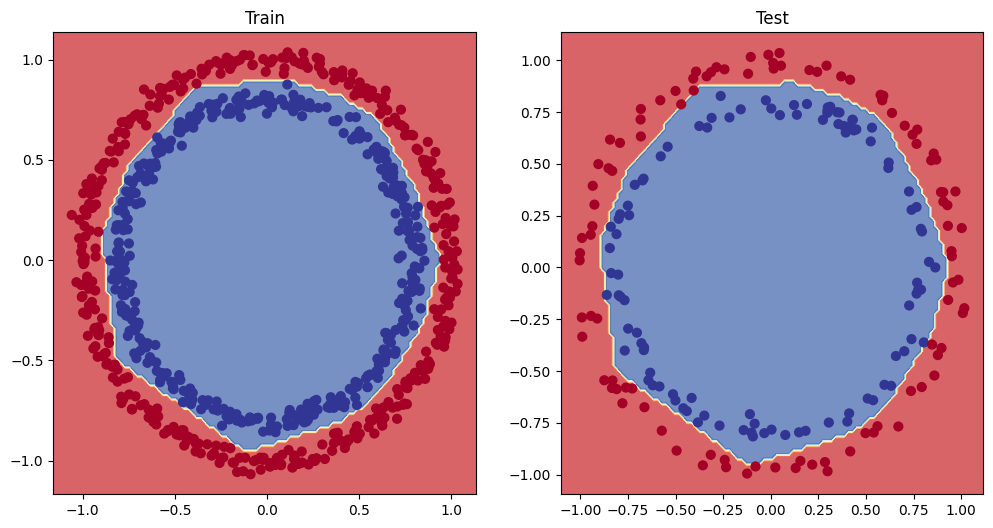

In [130]:
#Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [131]:
model_0.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.9802,  1.9256],
                      [-0.8889,  2.2796],
                      [-0.1549,  0.1427],
                      [-2.8940, -0.4035],
                      [ 0.8156, -2.8317],
                      [ 1.8095,  0.1576],
                      [ 1.7250,  0.5888],
                      [ 0.3410, -0.0998],
                      [ 1.4595, -0.5347],
                      [-0.3301,  0.1802]])),
             ('layers.0.bias',
              tensor([-0.2298, -1.0849, -0.2872, -0.7099, -0.7385, -0.8355, -0.7315, -0.4252,
                      -0.9728, -0.6984])),
             ('layers.2.weight',
              tensor([[ 0.8662,  0.9983,  0.2441,  1.1822,  1.1613,  0.8854,  0.5859,  0.2555,
                        0.7280, -0.0997],
                      [ 1.7215,  2.2745,  0.1331,  2.5221,  2.4908,  1.5550,  1.6990,  0.0566,
                        1.5171, -0.1927],
                      [ 0.6214,  0.8028, -0.2426,  0.9054,  0.8915,  